In [1]:
import sys
sys.path.insert(0, '../src')
sys.path.insert(0, '../')

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import numpy as np
import torch
import matplotlib.pyplot as plt

from drawing import draw_window, visualize_score_map
from image import get_image_tensor, get_numpy_image
from shape import Window, Position
from roi_align import RoIAlignFeatureExtractor
from matcher import CnnMatcher, Window
from image import load_image
from feature_extractor import CNN, ReCNN, ResizeImageFeatureExtractor, FeatureExtractor
from candidates import Candidates
from scorer import CosineSimilarityScorer, Scorer
from shape.basic import Size
from utils.timer import timer
from shape.basic import Point
from collections import defaultdict
from image import rotate_image
from scorer import MaxCosineSimilarityScorer


def visualize_result(img: np.ndarray, score_map: np.ndarray, threshold: float, rois: Candidates, best_window: Window, scores: torch.Tensor):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(img)
    axes[1].imshow(score_map)
    axes[2].imshow(score_map > threshold)

    windows = rois.rois.cpu().numpy()
    best_pos_indices = (windows[:, 1] == best_window.cx) & (windows[:, 2] == best_window.cy)
    best_pos_windows = windows[best_pos_indices]
    best_pos_scores = scores.reshape(-1)[best_pos_indices].cpu().numpy()
    angles = best_pos_windows[:, 5]
    axes[3].plot(angles, best_pos_scores)
    axes[3].set_xlabel('angle')
    axes[3].set_ylabel('score')
    axes[3].set_ylim(0.0, 1.0)
    plt.show()

Text(0.5, 1.0, 'template')

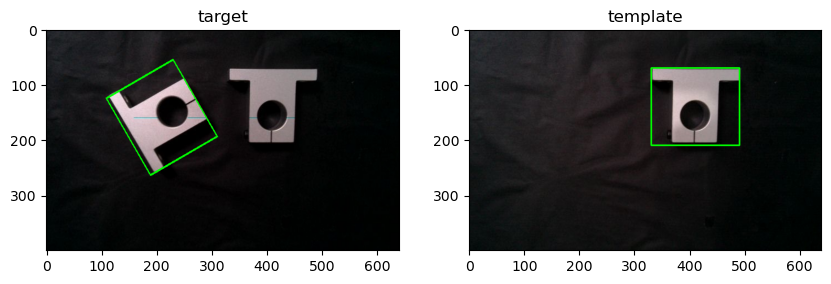

In [2]:
target_img = load_image('../data/image_1.png')
template_img = load_image('../data/template_1.jpg')

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

target_window = Window(210, 160, 160, 140, -120)
draw_img = draw_window(target_img, target_window)
axes[0].imshow(draw_img)
axes[0].set_title('target')

template_window = Window(410., 140., 160., 140., 0)
draw_img = draw_window(template_img, template_window)
axes[1].imshow(draw_img)
axes[1].set_title('template')

In [3]:
target_image_size = Size(*target_img.shape[:2])
template_size = template_window.get_size()
scales = [2, 4, 8, 16]

In [4]:
def evaluate(feature_extractor: FeatureExtractor, roi_feature_extractor: RoIAlignFeatureExtractor, scorer: Scorer, angle_step: int = 5):
    with timer('set template features'):
        template_feature_maps = feature_extractor(template_img)
        multiscale_template_features = defaultdict(list)
        for idx, scale in enumerate(scales):
            multiscale_template_features[scale] = roi_feature_extractor.extract(template_feature_maps[idx], template_window, spatial_scale=1.0/scale)

    with timer('search'):
        target_feature_maps = feature_extractor(target_img)

        for idx, scale in enumerate(scales):
            rois = Candidates(template_size, target_image_size, angle_step=angle_step, x_step=scale, y_step=scale)
            with timer('calc_roi_features'):
                roi_features = roi_feature_extractor.extract(target_feature_maps[idx], rois.rois, spatial_scale=1.0/scale)

            with timer('calc_scores'):
                template_features = multiscale_template_features[scale]
                scores = scorer.score(template_features, roi_features)
            best_score = scores.max()
            best_score_index = scores.argmax()

            num_steps = rois.get_num_steps()
            scores = scores.reshape(num_steps.y, num_steps.x, num_steps.angle)
            score_map = scores.max(-1).values.cpu().numpy()

            best_window = Window.from_array(rois[best_score_index])
            draw_img = draw_window(target_img, best_window)

            print(f'best score: {best_score:.4f} at {best_window}')
            visualize_result(draw_img, score_map, 0.8, rois, best_window, scores)


def evaluate_rotate(feature_extractor: FeatureExtractor, roi_feature_extractor: RoIAlignFeatureExtractor, scorer: MaxCosineSimilarityScorer, angle_step: int = 5, template_angle_step: int = 45):

    with timer('set template features'):
        rotated_imgs = []
        scales = [2, 4, 8, 16]
        multiscale_rotated_roi_features = defaultdict(list)
        
        img_h, img_w = template_img.shape[:2]
        rotation_center = Point((img_w - 1) * 0.5, (img_h - 1) * 0.5)
        
        for angle in range(0, 360, template_angle_step):
            rotated_img = rotate_image(template_img.copy(), angle)
            rotated_imgs.append(rotated_img)
            rotated_feature_maps = feature_extractor(rotated_img)
            rotated_window = template_window.rotate(rotation_center, angle)
            for idx, scale in enumerate(scales):
                rotated_roi_features = roi_feature_extractor.extract(rotated_feature_maps[idx], rotated_window, spatial_scale=1.0/scale)
                multiscale_rotated_roi_features[scale].append(rotated_roi_features)

        for scale in scales:
            multiscale_rotated_roi_features[scale] = torch.cat(multiscale_rotated_roi_features[scale], dim=0)
            print(multiscale_rotated_roi_features[scale].shape)

    with timer('search'):
        target_feature_maps = feature_extractor(target_img)

        for idx, scale in enumerate(scales):
            rois = Candidates(template_size, target_image_size, angle_step=angle_step, x_step=scale, y_step=scale)
            with timer('calc_roi_features'):
                roi_features = roi_feature_extractor.extract(target_feature_maps[idx], rois.rois, spatial_scale=1.0/scale)

            with timer('calc_scores'):
                template_features = multiscale_rotated_roi_features[scale]
                scores = scorer.score(template_features, roi_features)
            best_score = scores.max()
            best_score_index = scores.argmax()

            num_steps = rois.get_num_steps()
            scores = scores.reshape(num_steps.y, num_steps.x, num_steps.angle)
            score_map = scores.max(-1).values.cpu().numpy()

            best_window = Window.from_array(rois[best_score_index])
            draw_img = draw_window(target_img, best_window)

            print(f'best score: {best_score:.4f} at {best_window}')
            visualize_result(draw_img, score_map, 0.8, rois, best_window, scores)

# CNN

Elapsed time for set template features: 0.8590
Elapsed time for calc_roi_features   : 0.1692
Elapsed time for calc_scores         : 0.0031
best score: 0.9398 at Window(cx=410.0, cy=140.0, width=160.0, height=140.0, angle=0.0)


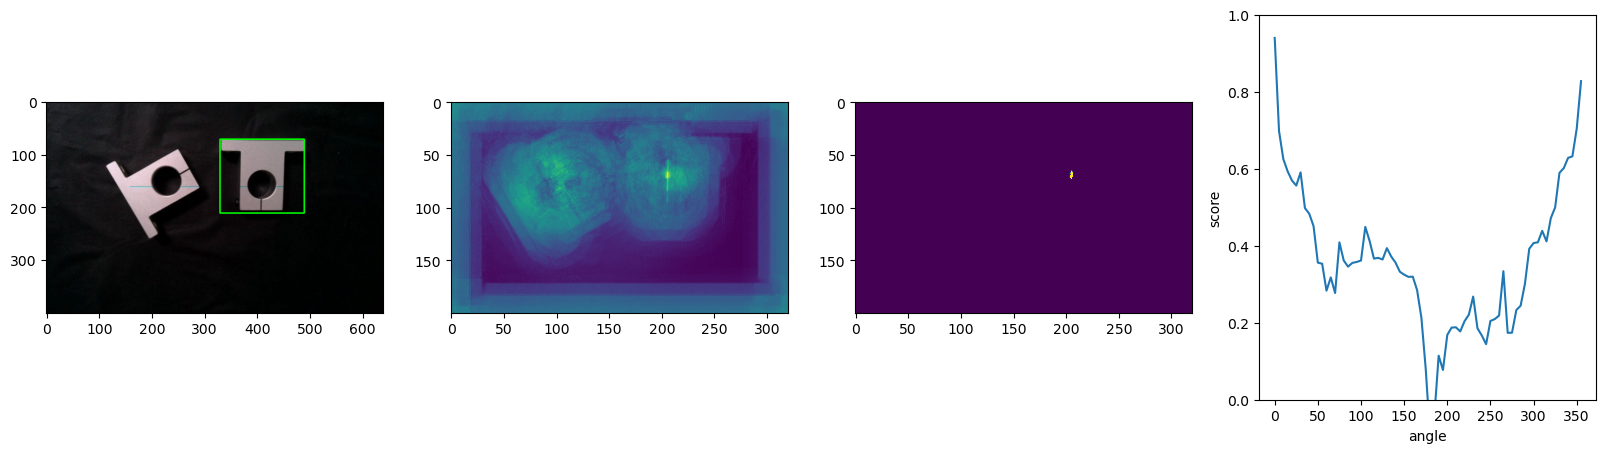

Elapsed time for calc_roi_features   : 0.0459
Elapsed time for calc_scores         : 0.0004
best score: 0.9168 at Window(cx=408.0, cy=140.0, width=160.0, height=140.0, angle=0.0)


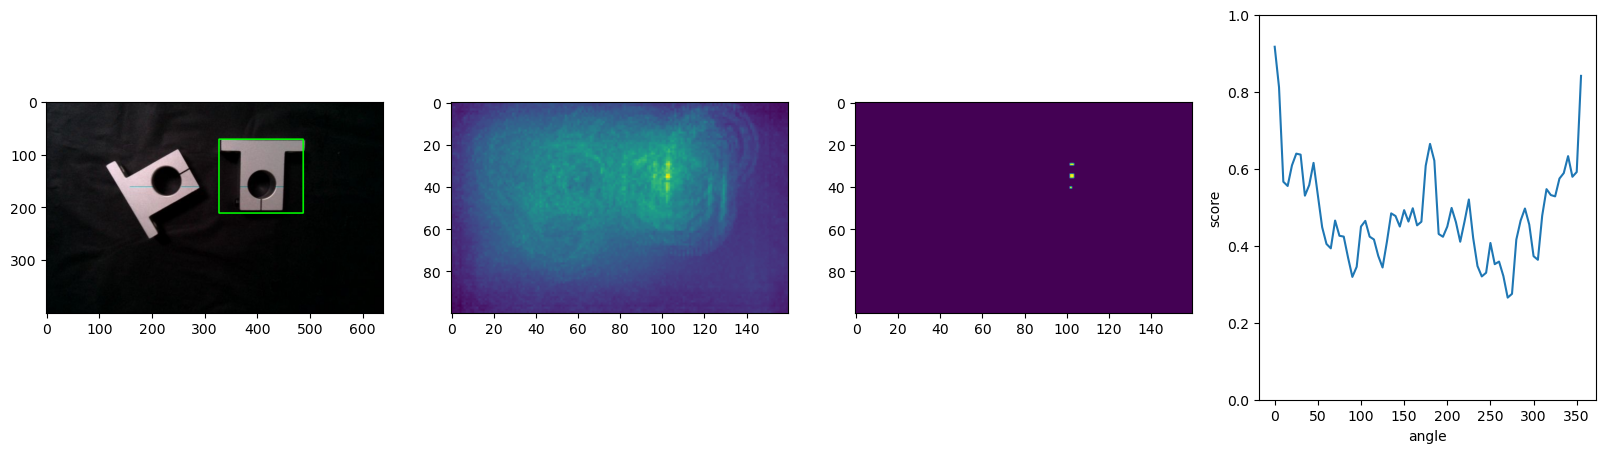

Elapsed time for calc_roi_features   : 0.0166
Elapsed time for calc_scores         : 0.0005
best score: 0.8153 at Window(cx=408.0, cy=136.0, width=160.0, height=140.0, angle=0.0)


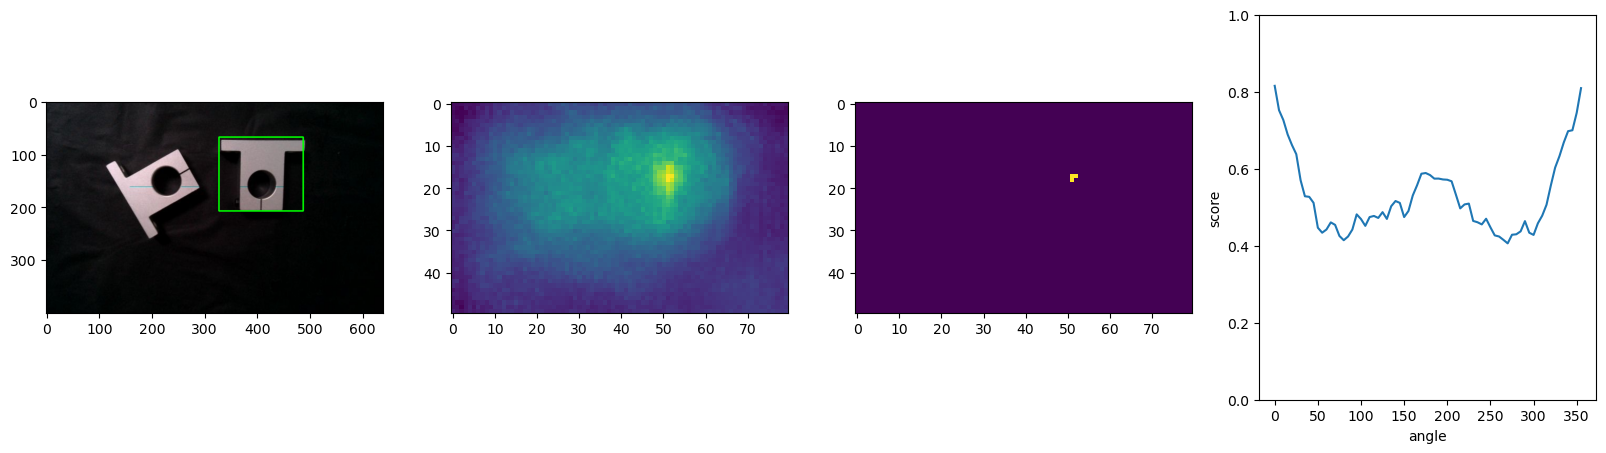

Elapsed time for calc_roi_features   : 0.0110
Elapsed time for calc_scores         : 0.0004
best score: 0.9005 at Window(cx=416.0, cy=144.0, width=160.0, height=140.0, angle=5.0)


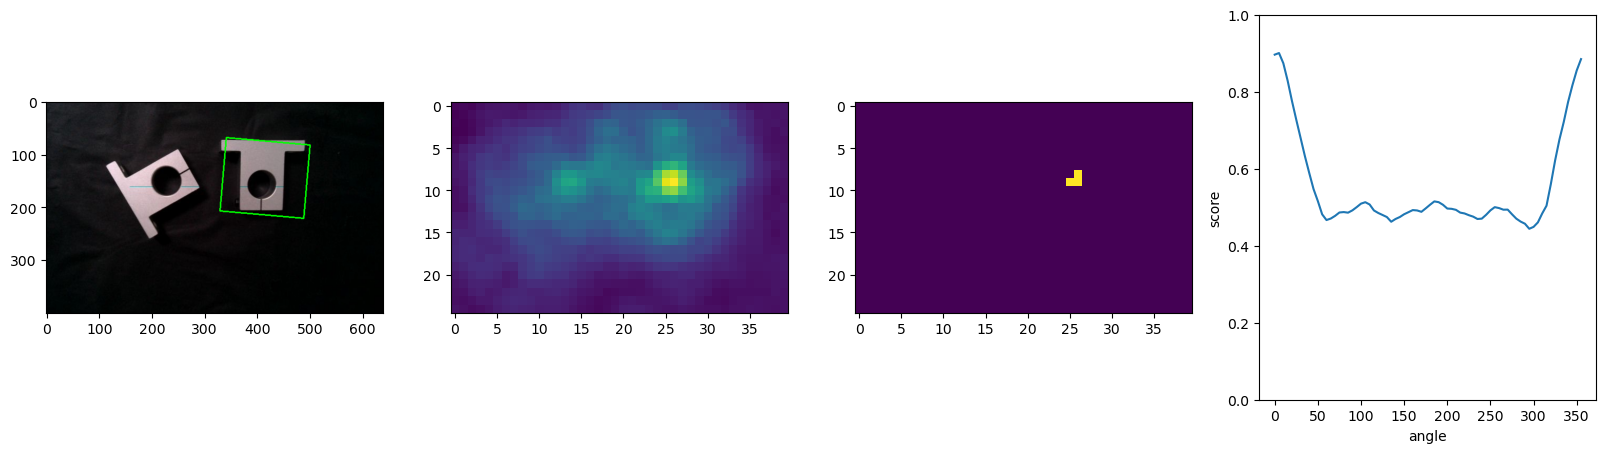

Elapsed time for search              : 7.4136
Elapsed time for evaluate            : 8.2728


In [5]:
device='cuda'
feature_extractor = CNN(device=device, pretrained=True)
roi_feature_extractor = RoIAlignFeatureExtractor(output_size=3, sampling_ratio=2, device=device)
scorer = CosineSimilarityScorer()
with timer('evaluate'):
    evaluate(feature_extractor, roi_feature_extractor, scorer)

torch.Size([18, 144])
torch.Size([18, 216])
torch.Size([18, 360])
torch.Size([18, 1008])
Elapsed time for set template features: 0.1283
Elapsed time for calc_roi_features   : 0.1647
Elapsed time for calc_scores         : 0.0011
best score: 0.9398 at Window(cx=410.0, cy=140.0, width=160.0, height=140.0, angle=0.0)


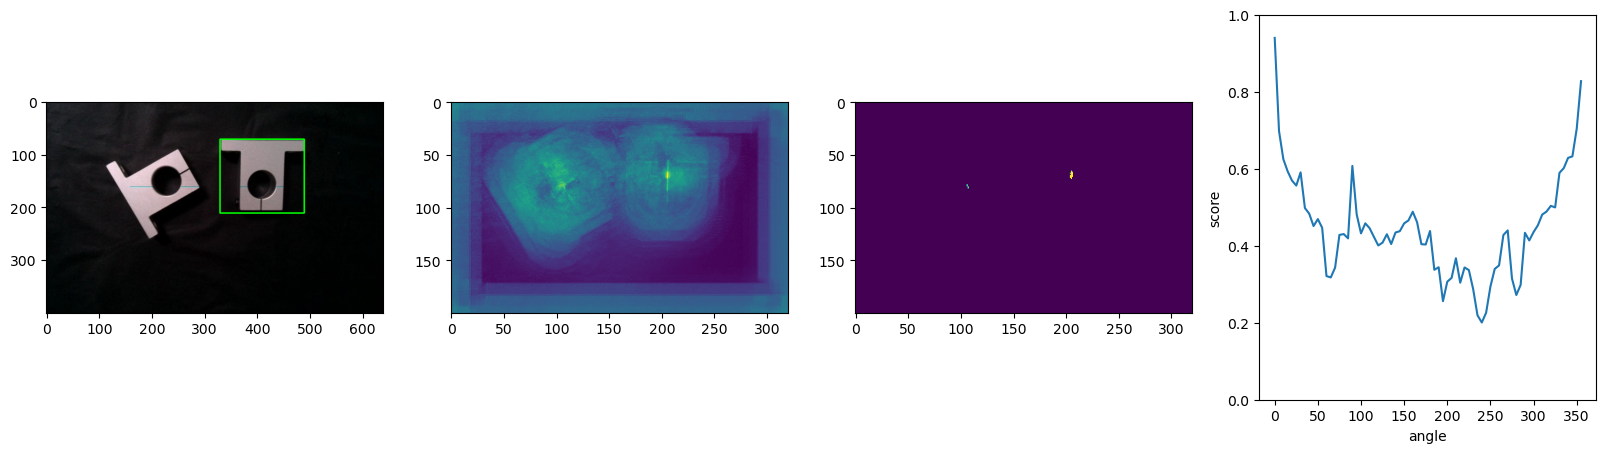

Elapsed time for calc_roi_features   : 0.0456
Elapsed time for calc_scores         : 0.0005
best score: 0.9168 at Window(cx=408.0, cy=140.0, width=160.0, height=140.0, angle=0.0)


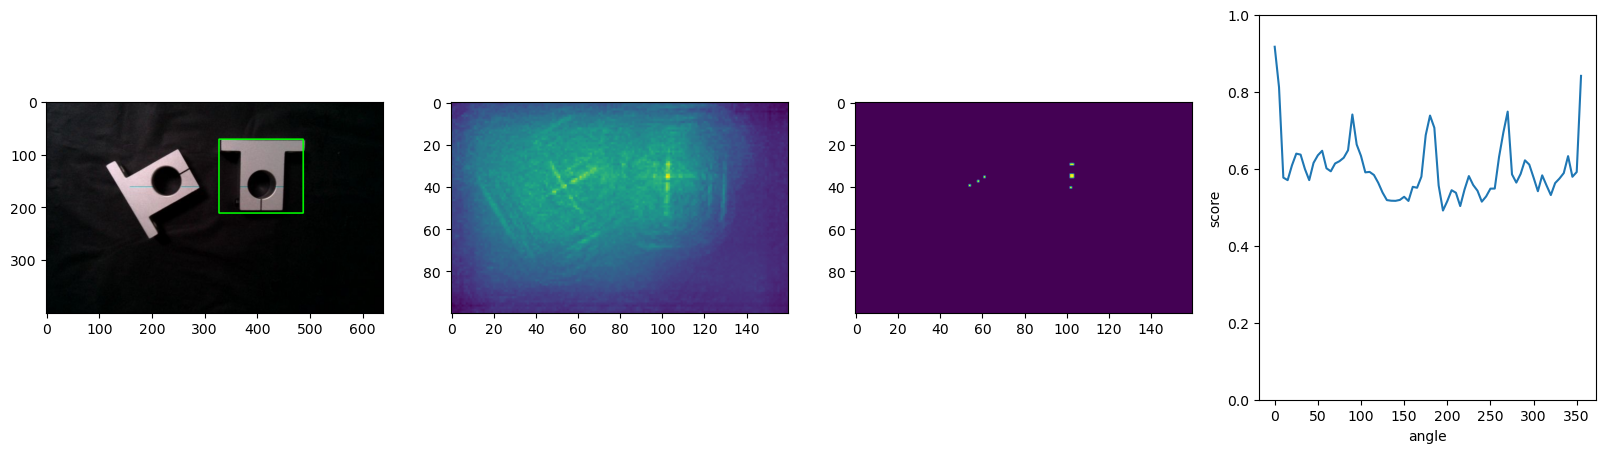

Elapsed time for calc_roi_features   : 0.0167
Elapsed time for calc_scores         : 0.0006
best score: 0.8153 at Window(cx=408.0, cy=136.0, width=160.0, height=140.0, angle=0.0)


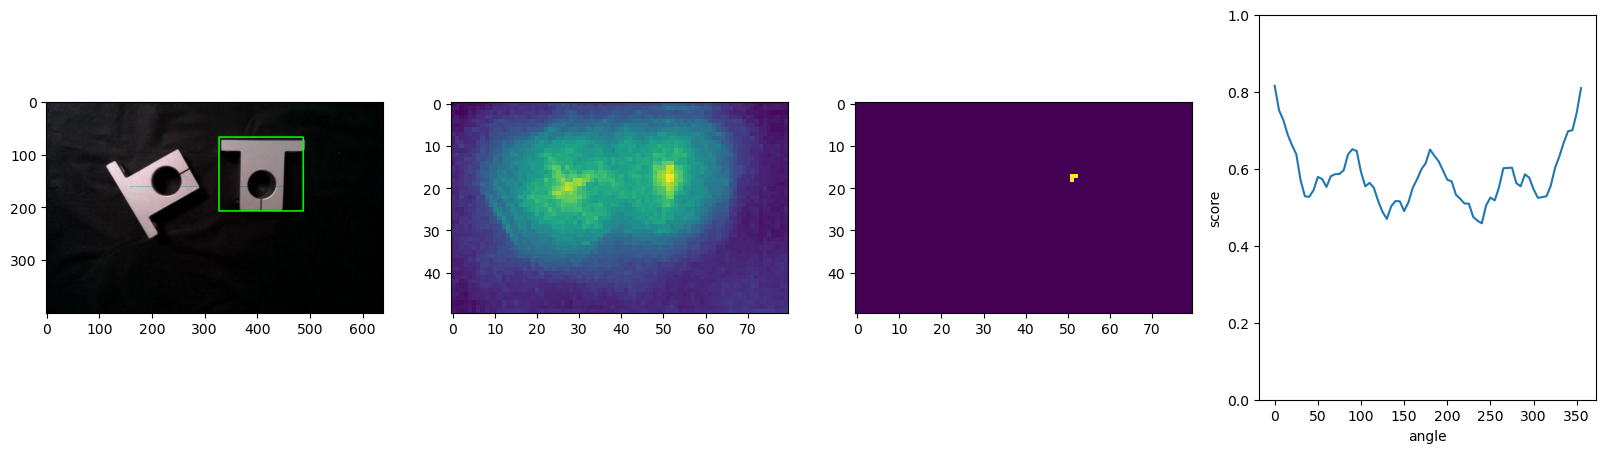

Elapsed time for calc_roi_features   : 0.0109
Elapsed time for calc_scores         : 0.0005
best score: 0.9005 at Window(cx=416.0, cy=144.0, width=160.0, height=140.0, angle=5.0)


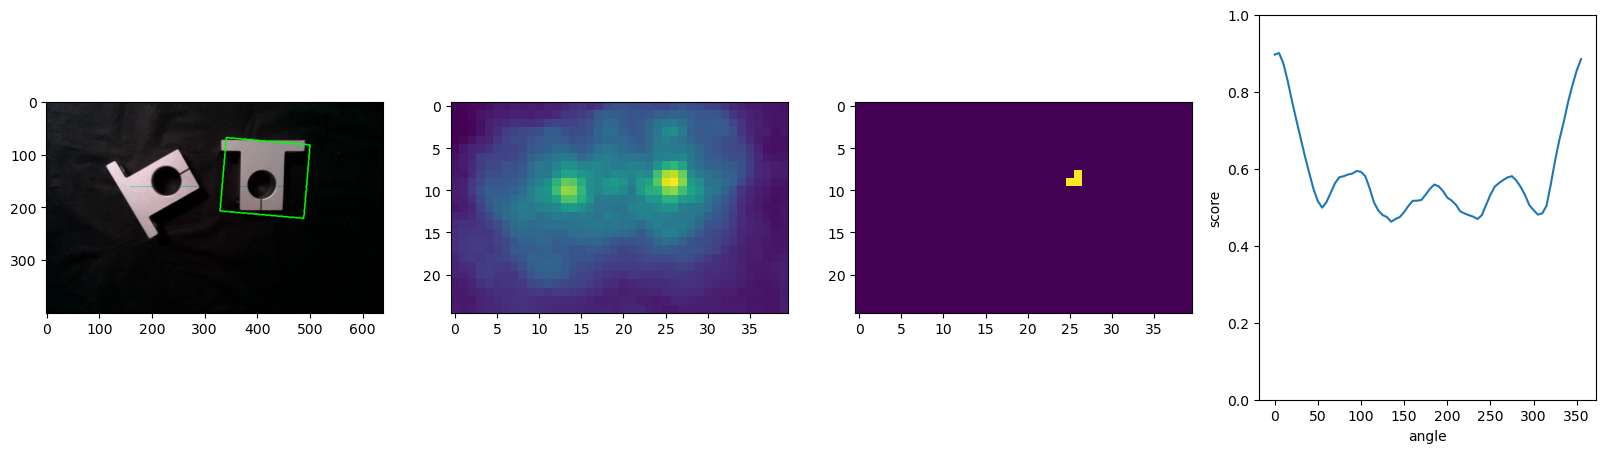

Elapsed time for search              : 7.5433
Elapsed time for evaluate            : 7.6718


In [6]:
device='cuda'
feature_extractor = CNN(device=device, pretrained=True)
roi_feature_extractor = RoIAlignFeatureExtractor(output_size=3, sampling_ratio=2, device=device)
scorer = MaxCosineSimilarityScorer()
with timer('evaluate'):
    evaluate_rotate(feature_extractor, roi_feature_extractor, scorer, template_angle_step=20)

# Pyramid search

In [7]:
# Prepare
with timer('calc_cnn1'):
    template_feature_maps = feature_extractor(template_img)
with timer('calc_cnn2'):
    target_feature_maps = feature_extractor(target_img)

Elapsed time for calc_cnn1           : 0.0111
Elapsed time for calc_cnn2           : 0.0069


In [8]:
for i, scale in enumerate(scales):
    template_roi_features = roi_feature_extractor.extract(template_feature_maps[i], template_window, spatial_scale=1.0 / scale)
    target_roi_features = roi_feature_extractor.extract(target_feature_maps[i], target_window, spatial_scale=1.0 / scale)
    score = scorer.score(template_roi_features, target_roi_features)
    print(i, scale, score)

0 2 tensor([0.2614], device='cuda:0')
1 4 tensor([0.3429], device='cuda:0')
2 8 tensor([0.3378], device='cuda:0')
3 16 tensor([0.4556], device='cuda:0')


Elapsed time for calc_cnn1           : 0.0063
Elapsed time for calc_cnn2           : 0.0053
Elapsed time for calc_roi_features   : 0.0109
Elapsed time for calc_scores         : 0.0003
best score: 0.9005 at Window(cx=416.0, cy=144.0, width=160.0, height=140.0, angle=5.0)


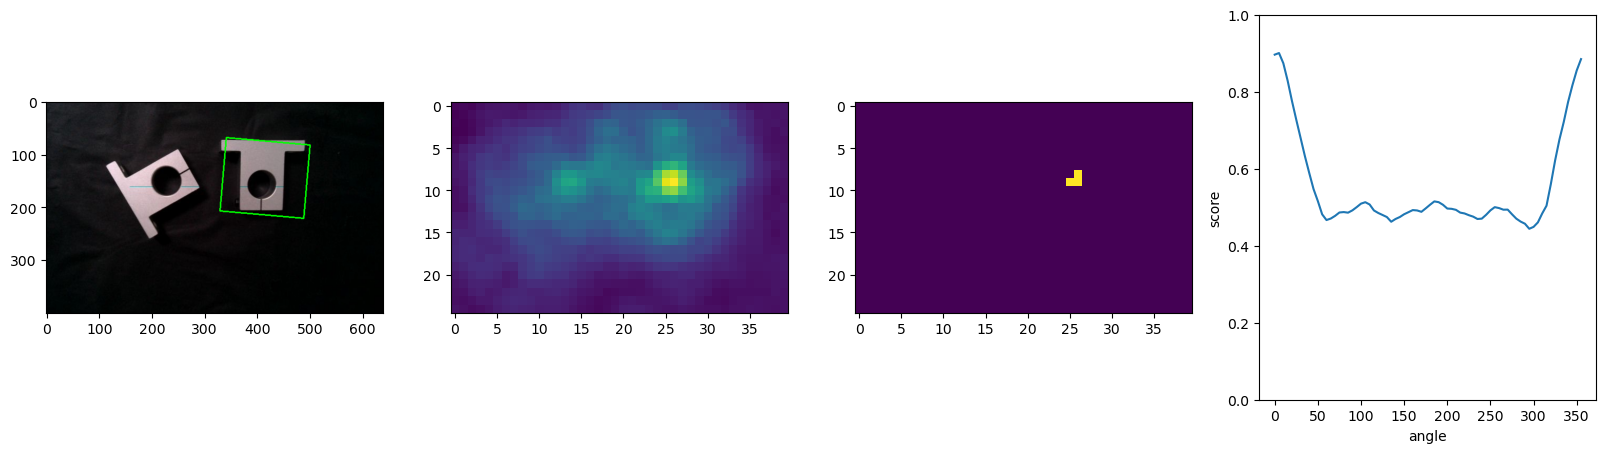

In [9]:
angle_step = 5

with timer('calc_cnn1'):
    template_feature_maps = feature_extractor(template_img)
with timer('calc_cnn2'):
    target_feature_maps = feature_extractor(target_img)

scales = [16, 8, 4, 2]
indices = [3, 2, 1, 0]
for idx, scale in zip(indices, scales):
    rois = Candidates(template_size, target_image_size, angle_step=angle_step, x_step=scale, y_step=scale)
    with timer('calc_roi_features'):
        roi_features = roi_feature_extractor.extract(target_feature_maps[idx], rois.rois, spatial_scale=1.0/scale)

    template_features = roi_feature_extractor.extract(template_feature_maps[idx], template_window, spatial_scale=1.0/scale)
    # template_features = roi_feature_extractor.extract(target_feature_maps[idx], target_window, spatial_scale=1.0/scale)

    with timer('calc_scores'):
        scores = scorer.score(template_features, roi_features)
    best_score = scores.max()
    best_score_index = scores.argmax()

    num_steps = rois.get_num_steps()
    scores = scores.reshape(num_steps.y, num_steps.x, num_steps.angle)
    score_map = scores.max(-1).values.cpu().numpy()

    best_window = Window.from_array(rois[best_score_index])
    draw_img = draw_window(target_img, best_window)

    print(f'best score: {best_score:.4f} at {best_window}')
    visualize_result(draw_img, score_map, 0.8, rois, best_window, scores)
    break

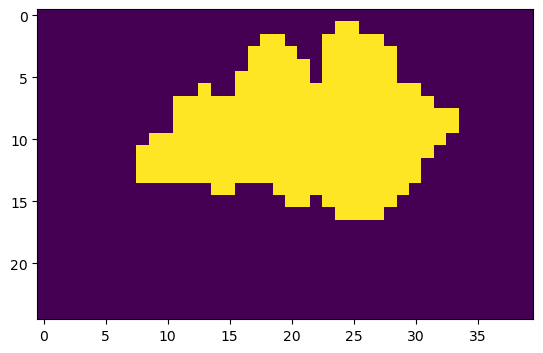

In [10]:
plt.imshow(score_map > 0.3)

# Check ground truth score

In [11]:
device='cuda'
roi_feature_extractor = RoIAlignFeatureExtractor(output_size=3, sampling_ratio=2, device=device)
scorer = CosineSimilarityScorer()

In [12]:
feature_extractor = CNN(device=device)

template_feature_maps = feature_extractor(template_img)
target_feature_maps = feature_extractor(target_img)

scales = [2, 4, 8, 16]
for idx, scale in enumerate(scales):
    roi_features = roi_feature_extractor.extract(target_feature_maps[idx], target_window, spatial_scale=1.0/scale)
    template_features = roi_feature_extractor.extract(template_feature_maps[idx], template_window, spatial_scale=1.0/scale)
    scores = scorer.score(template_features, roi_features).item()
    print(scores)

0.261427640914917
0.34288275241851807
0.33779674768447876
0.4555751085281372


In [21]:
feature_extractor = CNN(device=device)
scorer = MaxCosineSimilarityScorer()

template_angle_step = 180

rotated_imgs = []
scales = [2, 4, 8, 16]
multiscale_rotated_roi_features = defaultdict(list)

img_h, img_w = template_img.shape[:2]
rotation_center = Point((img_w - 1) * 0.5, (img_h - 1) * 0.5)

for angle in range(0, 360, template_angle_step):
    rotated_img = rotate_image(template_img.copy(), angle)
    rotated_imgs.append(rotated_img)
    rotated_feature_maps = feature_extractor(rotated_img)
    rotated_window = template_window.rotate(rotation_center, angle)
    for idx, scale in enumerate(scales):
        rotated_roi_features = roi_feature_extractor.extract(rotated_feature_maps[idx], rotated_window, spatial_scale=1.0/scale)
        multiscale_rotated_roi_features[scale].append(rotated_roi_features)

for scale in scales:
    multiscale_rotated_roi_features[scale] = torch.cat(multiscale_rotated_roi_features[scale], dim=0)
    print(multiscale_rotated_roi_features[scale].shape)


target_feature_maps = feature_extractor(target_img)

for idx, scale in enumerate(scales):
    template_features = multiscale_rotated_roi_features[scale]
    roi_features = roi_feature_extractor.extract(target_feature_maps[idx], target_window, spatial_scale=1.0/scale)
    scores = scorer.score(template_features, roi_features).item()
    print(scores)

# angle360
# 0.261427640914917
# 0.34288275241851807
# 0.33779674768447876
# 0.4555751085281372

# angle180
# 0.5447317361831665
# 0.48891884088516235
# 0.33779671788215637
# 0.5497989654541016
 
# angle90
# 0.5661988854408264
# 0.5483216047286987
# 0.4353106915950775
# 0.6545138359069824

# angle45
# 0.6506890058517456
# 0.7452381253242493
# 0.672773540019989
# 0.748525857925415

# angle30
# 0.6466821432113647
# 0.7517871856689453
# 0.7245186567306519
# 0.7715312242507935

# angle15
# 0.6506890058517456
# 0.7517871856689453
# 0.7245186567306519
# 0.7715312242507935

torch.Size([2, 144])
torch.Size([2, 216])
torch.Size([2, 360])
torch.Size([2, 1008])
0.5447317361831665
0.48891884088516235
0.33779671788215637
0.5497989654541016


In [15]:
# feature_extractor = ReCNN(device=device)

# template_feature_maps = feature_extractor(template_img)
# target_feature_maps = feature_extractor(target_img)

# scales = [2, 4, 8, 16]
# for idx, scale in enumerate(scales):
#     roi_features = roi_feature_extractor.extract(target_feature_maps[idx], target_window, spatial_scale=1.0/scale)
#     template_features = roi_feature_extractor.extract(template_feature_maps[idx], template_window, spatial_scale=1.0/scale)
#     scores = scorer.score(template_features, roi_features).item()
#     print(scores)